In [11]:
from tensorflow.keras.datasets.mnist import load_data


# Load the images into memory
(trainX, trainy), (testX, testy) = load_data()

print('Train', trainX.shape, trainy.shape)
print('Test' , testX.shape, testy.shape)



Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


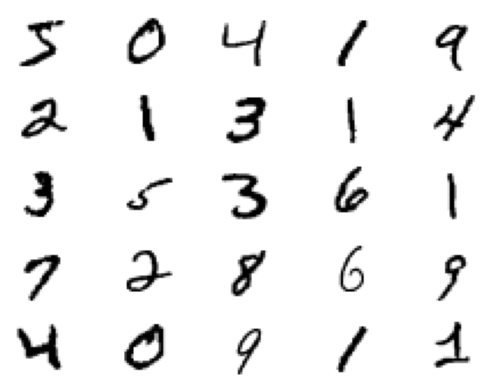

In [12]:
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
(trainX, trainy), (testX, testy) = load_data()
for i in range(25):
    # define the subplot
    pyplot.subplot(5,5, 1+i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()


In [13]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np 
import os 
import PIL
from tensorflow.keras import layers
import time 
import tensorflow as tf 

from IPython import display

In [14]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [15]:
train_images = train_images.reshape(train_images.shape[0],28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

In [16]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [47]:
# The generator and discriminator both are neural networks. We will write separate codes for both of them
#7*7*256 is a low level resolution of the output image which is the random noise version
#input_shape = (100,))) means that 100 is a one dimensional vector 
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # we reshape out model
    model.add(layers.Reshape((7,7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape ==(None, 7,7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    #unsample to 14*14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #unsample  to 28*28
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
    
                                     


    

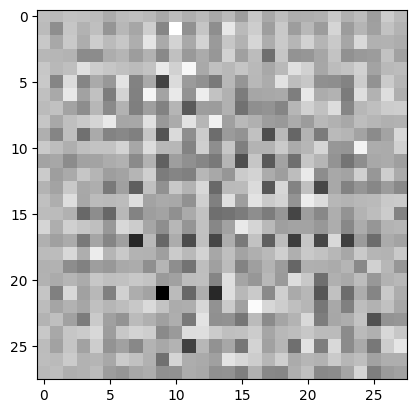

In [48]:
# noisy data sample image generated by the the generator
generator = make_generator_model()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

THE DISCRIMINATOR CLASSIFIER

In [49]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model



In [50]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5005226]], shape=(1, 1), dtype=float32)


In [80]:
#Define the loss and optimizers

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

Discriminator Loss


In [81]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [82]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

DISCRIMINATOR AND GENERATOR OPTIMIZERS


In [83]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [84]:
#checkpoint_dir = './training_checkpoints'
#checkpoints_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                               discriminator_optimizer=discriminator_optimizer,
#                              generator=generator,
#                               discriminator=discriminator)

In [85]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [86]:
  @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [87]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch +1) % 15 ==0:
        checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)
                                

In [88]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

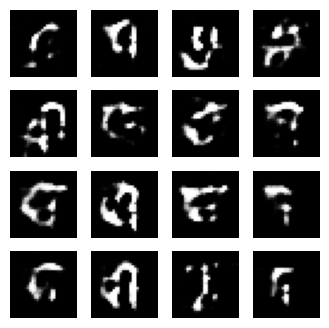

NameError: name 'checkpoint' is not defined

In [89]:
train(train_dataset, EPOCHS)

In [ ]:
train(train_dataset, EPOCHS)